In [1]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [2]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [3]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.5#0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 3000
Test set size: 3000


In [4]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])

In [5]:
from bin_and_delta import *

num_bins = 8
min_bin = 0
max_bin = 4

bin_idxs = np.zeros(len(t_x_data))
deltas = np.zeros(len(t_x_data))

for i in range(len(t_x_data)):
    bin_idxs[i], deltas[i] = get_bin_idx_and_delta(num_bins,min_bin,max_bin,t_x_data[i])

In [6]:
num_features = 1
num_frames = 2
input_size = num_features * num_frames
output_size = num_features #num_bins #num_features

In [14]:
dim1_data_scaled = bin_idxs

def prepare_data(dim1_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x here, no y and theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.9
train_ds,valid_ds = \
prepare_data(dim1_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([2998, 2])
x_train dimensions: torch.Size([2698, 2])
x_valid dimensions: torch.Size([300, 2])
y_data dimensions: torch.Size([2998, 1])
y_train dimensions: torch.Size([2698, 1])
y_valid dimensions: torch.Size([300, 1])


In [8]:
import torch.nn as nn
import torch.nn.functional as F
#our class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(2,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,num_bins)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x
        
    #This function takes an input and predicts the class       
    def predict(self,x):
        softm = nn.Softmax(dim=1)
        out = softm(model(X))
        return torch.argmax(out,dim=1)        

In [16]:
from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):
#     print(yb)
    yb = yb.reshape(len(yb))
    yb = yb.type(torch.LongTensor)
    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 30
epochs = 50
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = MyClassifier()
criterion = nn.CrossEntropyLoss()
loss_func = criterion
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 1.2630106806755066
1 0.9460049897432328
2 0.8146341621875763
3 0.7605495691299439
4 0.7169017493724823
5 0.6774672001600266
6 0.6420095816254616
7 0.6283292204141617
8 0.5940202161669731
9 0.5827758759260178
10 0.5596162155270576
11 0.5452313050627708
12 0.5303300432860851
13 0.5150821089744568
14 0.5102095626294613
15 0.4923101715743542
16 0.48937308341264724
17 0.48890830129384993
18 0.492795404791832
19 0.4732534006237984
20 0.4760432276874781
21 0.4553589653223753
22 0.4579826593399048
23 0.46399219147861004
24 0.44868914522230624
25 0.45941113494336605
26 0.4522615674883127
27 0.4527123298496008
28 0.44158252477645876
29 0.45165172331035136
30 0.4595399547368288
31 0.4493267823010683
32 0.44767887257039546
33 0.4451696157455444
34 0.45196646116673944
35 0.4446817021816969
36 0.43901997730135917
37 0.4418534226715565
38 0.4390145134180784
39 0.44298069886863234
40 0.4366403825581074
41 0.4238499511033297
42 0.44917342960834505
43 0.4190612304955721
44 0.4304298315197229
45 0.4318

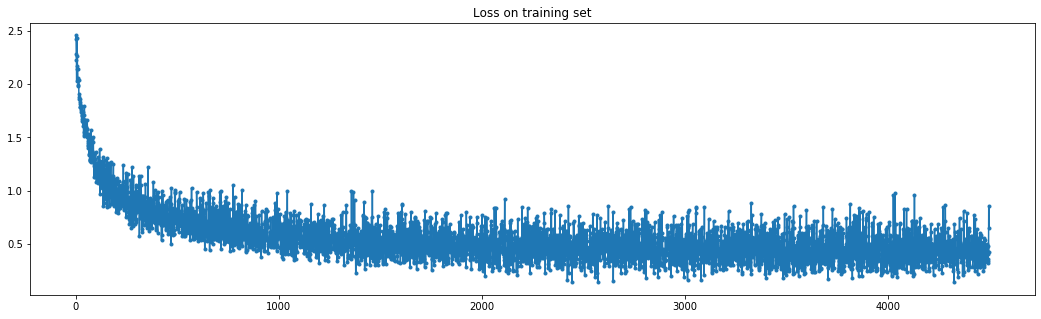

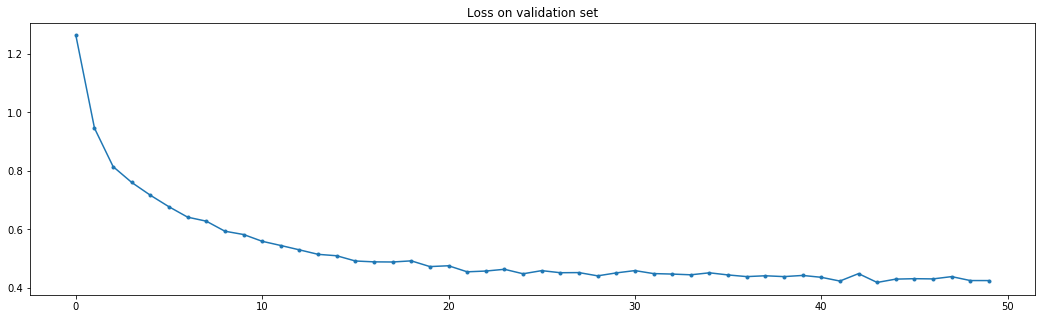

In [17]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')